In [5]:
import numpy as np
import matplotlib.pyplot as plt

points=100
T_th = np.linspace(0.2,3.0,num=points)
beta = 1/T_th
J = 1.0
Ns = 50
th = np.tanh(J/T_th)
thN= th**Ns
ch = 1/th

# TODO sistemare parametri simulazione per avere fit migliore (test a basse temperature)!!

21


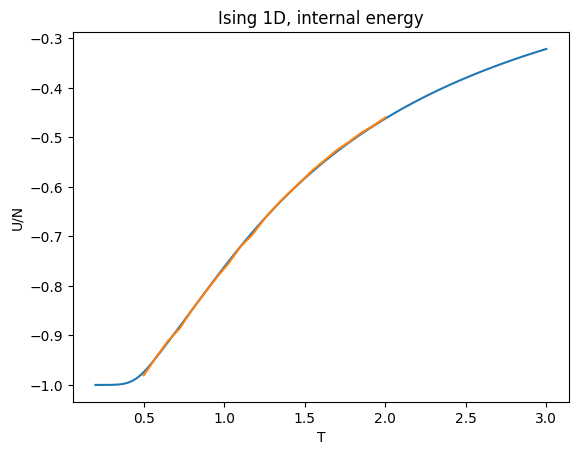

In [20]:
U_data = np.loadtxt("./ISING_1D/output.ene.0", delimiter=',')
U_data_final = []

for row in U_data:
    
    if row[0] == 20:
   
        U_data_final.append(row[1])

print(len(U_data_final))

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)
e = -J*( th + ch*thN )/( 1 + thN )
plt.plot(T_th, e)
plt.title('Ising 1D, internal energy')
plt.xlabel('T')
plt.ylabel('U/N')

plt.plot(T, U_data_final)
plt.show()

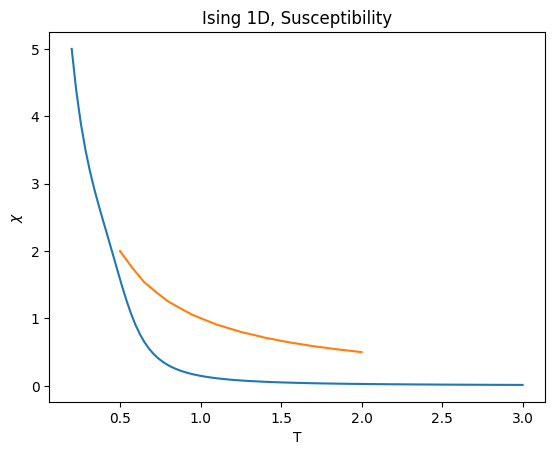

In [22]:
X_data = np.loadtxt("./ISING_1D/output.chi.0", delimiter = ',')
X_data_final = []

for idx, iter_num in enumerate(X_data[:,0]):
    
    if iter_num == 20:
        
        X_data_final.append(X_data[idx, 2])

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN) / Ns
plt.plot(T_th, X)
plt.title('Ising 1D, Susceptibility')
plt.xlabel('T')
plt.ylabel('$\chi$')
plt.plot(T, X_data_final)
plt.show()

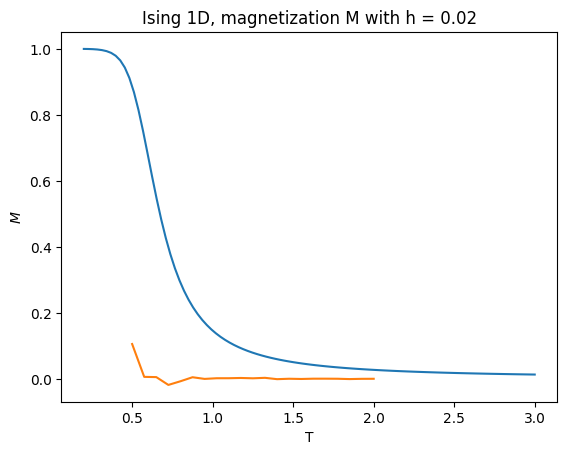

In [24]:
M_data = np.loadtxt("./ISING_1D/output.mag.0", delimiter = ',')
M_data_final = []

for idx, iter_num in enumerate(M_data[:,0]):
    
    if iter_num == 20:
        
        M_data_final.append(M_data[idx, 2])

T = np.arange(0.5, 2 + 1 / 20, 1.5/20)

h=0.02 #external field
b = 1/T_th

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
plt.plot(T_th, M)
plt.title('Ising 1D, magnetization M with h = 0.02')
plt.xlabel('T')
plt.ylabel('$M$')
plt.plot(T, M_data_final)
plt.show()